In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CTP1(x):
    f1 = x[0]
    f2 = (1.+x[1])*np.exp(-x[0]/(1.0+x[1]))
    return np.array([f1,f2])

def constraints(x):
    f1 = x[0]
    f2 = (1.+x[1])*np.exp(-x[0]/(1.0+x[1]))
    c1 = -1.0 + f2/(0.858*np.exp(-0.541*f1))
    c2 = -1.0 + f2/(0.728*np.exp(-0.295*f1))
    return np.array([c1,c2])

In [3]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (0.0,1.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (0.0,1.0)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1,model_c2]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 33
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))
C_init = np.zeros((X_init.shape[0],2))

for i in range(num_init):
    Y_init[i,:] = CTP1(X_init[i,:])
    C_init[i,:] = constraints(X_init[i,:])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init,C_init)))

[[ 0.1667  0.8333  0.1667  1.674   1.1352  1.4154]
 [ 0.3182  0.2273  0.3182  0.947   0.311   0.4288]
 [ 0.3485  0.7121  0.3485  1.3968  0.9658  1.1264]
 [ 0.9545  0.1061  0.9545  0.4666 -0.0885 -0.1505]
 [ 0.3788  0.5606  0.3788  1.2243  0.7514  0.8805]
 [ 0.5     0.9848  0.5     1.5429  1.3568  1.4561]
 [ 0.0152  0.2576  0.0152  1.2425  0.4601  0.7144]
 [ 0.1364  0.803   0.1364  1.6717  1.0975  1.3905]
 [ 0.0455  0.5909  0.0455  1.5461  0.8468  1.1524]
 [ 0.9242  0.3485  0.9242  0.6795  0.3057  0.2259]
 [ 0.9848  0.4697  0.9848  0.752   0.4932  0.3812]
 [ 0.2273  0.1667  0.2273  0.9602  0.2655  0.4104]
 [ 0.5606  0.0455  0.5606  0.6115 -0.0347 -0.0089]
 [ 0.4697  0.0758  0.4697  0.6952  0.0446  0.0968]
 [ 0.2879  0.9545  0.2879  1.6869  1.2974  1.5225]
 [ 0.803   0.7727  0.803   1.127   1.0281  0.9618]
 [ 0.7424  0.2879  0.7424  0.7236  0.2603  0.2374]
 [ 0.5303  0.6818  0.5303  1.227   0.9052  0.9708]
 [ 0.5909  0.9242  0.5909  1.4154  1.2711  1.3146]
 [ 0.7121  0.4394  0.7121  0.87

In [7]:
iter_count = 150-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    C_clip = np.copy(C_step)
    C_clip[C_clip > 0] = 0.0
    C_clip = np.sum(C_clip**2,axis=1)
    
    Pareto = ParetoFront(Y_step[C_clip==0.0,:])
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,jitter_c = np.array([0.0,0.0,0.0,0.0,0.0,0.0]),
                                  P=Pareto,r=np.array([1.0,1.1]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                                        model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = CTP1(x_next[0])
    c_next = constraints(x_next[0])
    print("Current iteration - ",current_iter," : ",np.hstack((x_next[0],y_next,c_next)))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

(5, 2)
Current iteration -  0  :  [0.     0.     0.     1.     0.1655 0.3736]
(4, 2)
Current iteration -  1  :  [0.6196 0.0863 0.6196 0.614  0.0007 0.0126]
(5, 2)
Current iteration -  2  :  [0.3191 0.     0.3191 0.7268 0.0067 0.0969]
(6, 2)
Current iteration -  3  :  [0.0964 0.     0.0964 0.9081 0.1151 0.2834]
(7, 2)
Current iteration -  4  :  [5.0075e-01 5.3116e-02 5.0075e-01 6.5459e-01 3.1538e-04 4.2303e-02]
(8, 2)
Current iteration -  5  :  [0.2479 0.     0.2479 0.7805 0.0402 0.1534]
(9, 2)
Current iteration -  6  :  [7.2309e-01 1.2130e-01 7.2309e-01 5.8838e-01 1.4066e-02 3.8962e-04]
(10, 2)
Current iteration -  7  :  [0.0477 0.     0.0477 0.9535 0.1403 0.3282]
(11, 2)
Current iteration -  8  :  [3.9350e-01 2.0264e-02 3.9350e-01 6.9376e-01 4.1046e-04 7.0270e-02]
(11, 2)
Current iteration -  9  :  [0.1461 0.     0.1461 0.8641 0.0899 0.2392]
(12, 2)
Current iteration -  10  :  [5.5987e-01 6.9847e-02 5.5987e-01 6.3394e-01 2.3815e-04 2.7176e-02]
(13, 2)
Current iteration -  11  :  [4.47

Current iteration -  92  :  [0.2571 0.     0.2571 0.7733 0.0358 0.1459]
(89, 2)
Current iteration -  93  :  [0.2538 0.0048 0.2538 0.7805 0.0436 0.1555]
(89, 2)
Current iteration -  94  :  [0.1273 0.     0.1273 0.8805 0.0993 0.2557]
(90, 2)
Current iteration -  95  :  [4.8205e-01 4.7477e-02 4.8205e-01 6.6112e-01 1.2403e-04 4.6910e-02]
(91, 2)
Current iteration -  96  :  [9.7652e-02 7.4563e-04 9.7652e-02 9.0771e-01 1.1533e-01 2.8329e-01]
(92, 2)
Current iteration -  97  :  [0.347  0.2657 0.347  0.9622 0.353  0.4642]
(92, 2)
Current iteration -  98  :  [0.718  0.1202 0.718  0.5901 0.0143 0.0018]
(93, 2)
Current iteration -  99  :  [5.8459e-03 2.5324e-04 5.8459e-03 9.9442e-01 1.6267e-01 3.6833e-01]
(93, 2)
Current iteration -  100  :  [0.1974 0.     0.1974 0.8209 0.0646 0.1952]
(94, 2)
Current iteration -  101  :  [7.3308e-01 1.2519e-01 7.3308e-01 5.8651e-01 1.6313e-02 1.4725e-04]
(95, 2)
Current iteration -  102  :  [3.6304e-01 1.0053e-02 3.6304e-01 7.0509e-01 1.3256e-04 7.8022e-02]
(96, 

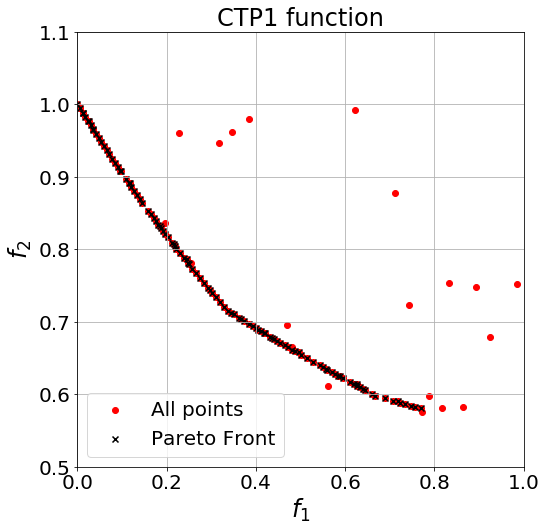

In [11]:
import matplotlib.pyplot as plt

C_clip = np.copy(C_step)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_step[C_clip==0.0,:])

fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='lower left',fontsize=20)
plt.xlim((0.0,1.0))
plt.ylim((0.5,1.1))

plt.grid()

plt.title("CTP1 function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("CTP1.png",bbox_inches='tight')
plt.show()

In [12]:
np.savez('CTP1.npz',X_step=X_step,Y_step=Y_step,C_step=C_step)